# Regularización con California Housing

### Ejercicio
Utilice el dataset California Housing que contiene datos de características demográficas y geográficas de distritos de California para generar una red neuronal capaz de predecir el precio medio de las viviendas. Realice un análisis del efecto de la regularización comparando 4 versiones del modelo: sin regularización, con regularización L1 (Lasso), con regularización L2 (Ridge) y con regularización L1-L2 (Elastic Net).
Utilice la siguiente configuración: 3 capas ocultas (128, 64 y 32 neuronas) con función de activación relu, optimizador Adam, división en datos de entrenamiento, validación (30% del total) y prueba (15% del total). El dataset debe normalizarse usando StandardScaler. Aplique early stopping con paciencia de 15 épocas. Para la regularización, utilice un strength de 0.01 para L2 y L1, y para Elastic Net use l1_ratio=0.5. Entrene los modelos con un máximo de 200 épocas y calcule el tiempo de entrenamiento.
Luego del entrenamiento, evalúe los modelos en dos escenarios:
1.	Sin ruido: utilizando los datos de prueba originales
2.	Con ruido: añadiendo ruido gaussiano a los datos de prueba con niveles de 0.1, 0.3, 0.5 y 1.0 de desviación estándar

## Regularización
* ### Sin Regularización
  * Función de Costo y Derivada: Loss(y, ŷ) ➔  ∇Loss(y, ŷ)
  * Efecto en Pesos: Crecimiento libre sin restricciones
  * Ventajas: Máxima flexibilidad, máxima capacidad de ajuste
  * Desventajas: Riesgo de overfitting, poca generalización

* ### L1 (Lasso)
  * Función de Costo y Derivada: Loss(y, ŷ) + λ·Σ|w| ➔ ∇Loss(y, ŷ) + λ·sign(w)
  * Efecto en Pesos: Esparsidad, pesos cercanos a cero
  * Ventajas: Selección de features, modelos interpretables, reduce dimensionalidad
  * Desventajas: Puede eliminar features importantes, inestable con features correlacionados

* ### L2 (Ridge)
  * Función de Costo y Derivada: Loss(y, ŷ) + λ·Σw² ➔ ∇Loss(y, ŷ) + 2·λ·w
  * Efecto en Pesos: Contracción uniforme - pesos pequeños
  * Ventajas: Estabilidad numérica, maneja features correlacionados, siempre tiene solución
  * Desventajas: No crea esparsidad, todos los features se mantienen

* ### L1+L2 (Elastic Net)
    * Función de Costo y Derivada: Loss(y, ŷ) + λ₁·Σ|w| + λ₂·Σw² ➔ ∇Loss(y, ŷ) + λ₁·sign(w) + 2λ₂·w
    * Efecto en Pesos: Balance entre esparsidad y contracción
    * Ventajas: Combina ventajas de L1 y L2, robustez, maneja grupos de features
    * Desventajas: Dos parámetros a ajustar, más complejo de optimizar

## Carga y Preparación de Datos
Carga del dataset con API de Scikit-Learn. División del dataset en entrenamiento, validación y prueba.

In [3]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import time

# Carga del Dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalizacion
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Creación y Entrenamiento de Modelos

In [4]:
# funcion para crear la misma arquitectura del modelo con diferentes regularizaciones
def crear_modelo(reg_type='none', l1=0.01, l2=0.01):
    if reg_type == 'none':
        reg = None
    elif reg_type == 'l1':
        reg = keras.regularizers.L1(l1)
    elif reg_type == 'l2':
        reg = keras.regularizers.L2(l2)
    else:  # elastic_net
        reg = keras.regularizers.L1L2(l1=l1, l2=l2)

    model = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=reg),
        keras.layers.Dense(64, activation='relu', kernel_regularizer=reg),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=reg),
        keras.layers.Dense(1)
    ])
    # compila modelo para computar mse y mae
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [5]:
modelos = [
    ('Sin Regularización', 'none'),
    ('L1 (Lasso)', 'l1'),
    ('L2 (Ridge)', 'l2'),
    ('L1+L2 (Elastic Net)', 'elastic_net')
]

resultados = []

for nombre, tipo in modelos:
    print(f"\nEntrenando: {nombre} (puede tardar)...")
    modelo = crear_modelo(tipo)

    inicio = time.time() # tiempo de inicio
    history = modelo.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=200, batch_size=32, verbose=0,
                         callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)])
    tiempo = time.time() - inicio # tiempo total de entrenmiento

    # agrega el modelo a la lista con información asociada
    resultados.append({'nombre': nombre, 'modelo': modelo, 'history': history, 'tiempo': tiempo})
    print(f"Tiempo: {tiempo:.2f}s - Épocas: {len(history.history['loss'])} - Tiempo Época: {tiempo/len(history.history['loss']):.2f}s")


Entrenando: Sin Regularización (puede tardar)...
Tiempo: 42.03s - Épocas: 82 - Tiempo Época: 0.51s

Entrenando: L1 (Lasso) (puede tardar)...
Tiempo: 105.51s - Épocas: 196 - Tiempo Época: 0.54s

Entrenando: L2 (Ridge) (puede tardar)...
Tiempo: 93.74s - Épocas: 171 - Tiempo Época: 0.55s

Entrenando: L1+L2 (Elastic Net) (puede tardar)...
Tiempo: 142.61s - Épocas: 200 - Tiempo Época: 0.71s


### Curvas de Entrenamiento y Validación

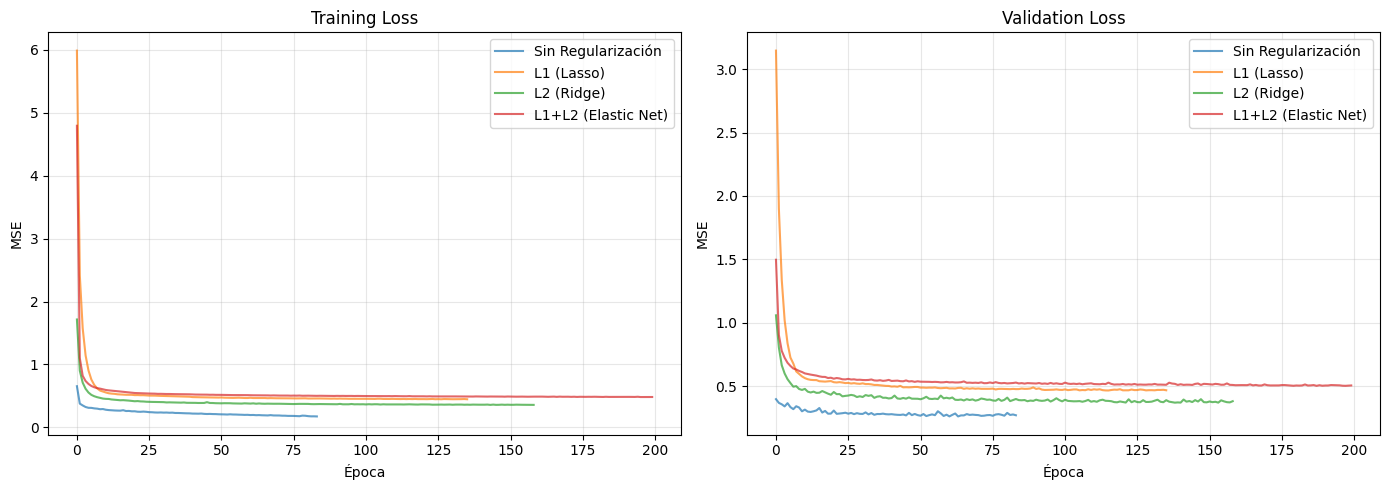

In [3]:
# Curvas de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for r in resultados:
    ax1.plot(r['history'].history['loss'], label=r['nombre'], alpha=0.7)
    ax2.plot(r['history'].history['val_loss'], label=r['nombre'], alpha=0.7)
ax1.set_title('Training Loss')
ax1.set_xlabel('Época')
ax1.set_ylabel('MSE')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax2.set_title('Validation Loss')
ax2.set_xlabel('Época')
ax2.set_ylabel('MSE')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Pesos por Modelo
Amplitud y valores cercanos a cero de los pesos de los modelos

In [8]:
import plotly.graph_objects as go

import numpy as np

# Calcular pesos cercanos a cero para cada modelo
for r in resultados:
    pesos = r['modelo'].layers[0].get_weights()[0].flatten()

    # Definir umbral para considerar un peso como "cero"
    # Puedes ajustar este valor según lo que consideres significativo
    umbral_cero = 1e-4

    # Contar pesos cercanos a cero
    pesos_cercanos_cero = np.sum(np.abs(pesos) < umbral_cero)
    total_pesos = len(pesos)
    porcentaje_cero = (pesos_cercanos_cero / total_pesos) * 100

    print(f"{r['nombre']}:")
    print(f"  Pesos cercanos a cero (< {umbral_cero})....: {pesos_cercanos_cero} de {total_pesos}")
    print(f"  Porcentaje de pesos cercanos a cero: {porcentaje_cero:.2f}%")
    print(f"  Suma de valores absolutos..........: {np.sum(np.abs(pesos)):.4f}")
    print(f"  Desviación estándar................: {np.std(pesos):.6f}")
    print("-" * 50)


# Pesos de la primera capa - Distribución interactiva
fig = go.Figure()

for r in resultados:
    pesos = r['modelo'].layers[0].get_weights()[0].flatten()
    counts, bins = np.histogram(pesos, bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Filtrar solo donde hay valores
    mask = counts > 0
    bin_centers_filtered = bin_centers[mask]
    counts_filtered = counts[mask]

    suma_abs = np.sum(np.abs(pesos))
    desv = np.std(pesos)

    fig.add_trace(go.Scatter(
        x=bin_centers_filtered,
        y=counts_filtered,
        mode='lines+markers',
        name=f"{r['nombre']}",
        hovertemplate='<b>%{fullData.name}</b><br>' +
                      'Peso: %{x:.4f}<br>' +
                      'Frecuencia: %{y}<br>' +
                      f'Σ|w|: {suma_abs:.2f}<br>' +
                      f'σ: {desv:.4f}<extra></extra>',
        line=dict(width=2),
        marker=dict(size=6)
    ))

fig.update_layout(
    title='Distribución de Pesos - Primera Capa',
    xaxis_title='Valor del peso',
    yaxis_title='Frecuencia',
    hovermode='closest',
    template='plotly_white',
    width=1300,
    height=600

)

fig.show()

Sin Regularización:
  Pesos cercanos a cero (< 0.0001)....: 0 de 1024
  Porcentaje de pesos cercanos a cero: 0.00%
  Suma de valores absolutos..........: 173.3907
  Desviación estándar................: 0.277170
--------------------------------------------------
L1 (Lasso):
  Pesos cercanos a cero (< 0.0001)....: 562 de 1024
  Porcentaje de pesos cercanos a cero: 54.88%
  Suma de valores absolutos..........: 3.2309
  Desviación estándar................: 0.044405
--------------------------------------------------
L2 (Ridge):
  Pesos cercanos a cero (< 0.0001)....: 855 de 1024
  Porcentaje de pesos cercanos a cero: 83.50%
  Suma de valores absolutos..........: 12.9251
  Desviación estándar................: 0.047547
--------------------------------------------------
L1+L2 (Elastic Net):
  Pesos cercanos a cero (< 0.0001)....: 553 de 1024
  Porcentaje de pesos cercanos a cero: 54.00%
  Suma de valores absolutos..........: 2.0921
  Desviación estándar................: 0.028068
--------------

## Evaluación del Modelo
Evaluación del modelo con datos de prueba. Se hacen 5 pruebas, una directamente con los datos de prueba y las cuatro restantes con la progresión al azar de ruido Gaussiano.

In [5]:
print(f"\n--- Sin Ruido ---")
for r in resultados:
    mse, mae = r['modelo'].evaluate(X_test, y_test, verbose=0)
    r['mse_limpio'] = mse
    r['mae_limpio'] = mae
    print(f"{r['nombre']:20} - MSE: {mse:.4f}, MAE: {mae:.4f}")

# niveles de ruido (Gaussiano) para agregar a los datos de prueba
niveles_ruido = [0.1, 0.3, 0.5, 1.0]

for nivel in niveles_ruido:
    print(f"\n--- Ruido: {nivel} ---")
    X_ruido = X_test + np.random.normal(0, nivel, X_test.shape)

    for r in resultados:
        mse, mae = r['modelo'].evaluate(X_ruido, y_test, verbose=0)
        if 'ruido' not in r:
            r['ruido'] = {}
        r['ruido'][nivel] = {'mse': mse, 'mae': mae}
        print(f"{r['nombre']:20} - MSE: {mse:.4f}, MAE: {mae:.4f}")



--- Sin Ruido ---
Sin Regularización   - MSE: 0.2377, MAE: 0.3268
L1 (Lasso)           - MSE: 0.4192, MAE: 0.4192
L2 (Ridge)           - MSE: 0.3379, MAE: 0.3725
L1+L2 (Elastic Net)  - MSE: 0.4631, MAE: 0.4491

--- Ruido: 0.1 ---
Sin Regularización   - MSE: 0.9952, MAE: 0.6576
L1 (Lasso)           - MSE: 0.7675, MAE: 0.6022
L2 (Ridge)           - MSE: 0.6410, MAE: 0.5455
L1+L2 (Elastic Net)  - MSE: 0.6300, MAE: 0.5499

--- Ruido: 0.3 ---
Sin Regularización   - MSE: 4.1190, MAE: 1.3114
L1 (Lasso)           - MSE: 2.4770, MAE: 1.1239
L2 (Ridge)           - MSE: 2.2604, MAE: 1.0809
L1+L2 (Elastic Net)  - MSE: 1.6094, MAE: 0.9209

--- Ruido: 0.5 ---
Sin Regularización   - MSE: 10.1130, MAE: 1.9758
L1 (Lasso)           - MSE: 4.2387, MAE: 1.5182
L2 (Ridge)           - MSE: 3.8756, MAE: 1.4617
L1+L2 (Elastic Net)  - MSE: 2.6170, MAE: 1.2009

--- Ruido: 1.0 ---
Sin Regularización   - MSE: 53.9918, MAE: 4.2161
L1 (Lasso)           - MSE: 9.1882, MAE: 2.2318
L2 (Ridge)           - MSE: 8.1599,

## Gráfico de Degradación con todas las Variantes del Modelo

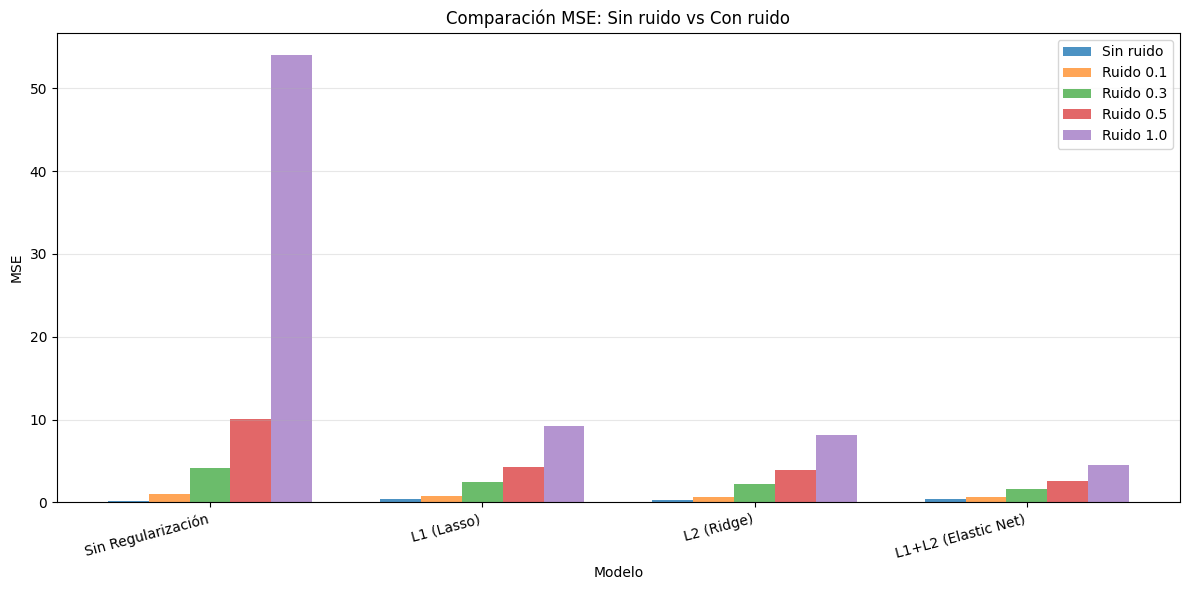

DEGRADACIÓN POR RUIDO (razon MSE_ruido / MSE_limpio)
Sin Regularización   4.19x      17.33x     42.55x     227.18x   
L1 (Lasso)           1.83x      5.91x      10.11x     21.92x    
L2 (Ridge)           1.90x      6.69x      11.47x     24.15x    
L1+L2 (Elastic Net)  1.36x      3.48x      5.65x      9.71x     


In [6]:
# Comparación con ruido
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(resultados))
width = 0.15

mse_limpio = [r['mse_limpio'] for r in resultados]
ax.bar(x, mse_limpio, width, label='Sin ruido', alpha=0.8)

for i, nivel in enumerate(niveles_ruido):
    mse_ruido = [r['ruido'][nivel]['mse'] for r in resultados]
    ax.bar(x + (i+1)*width, mse_ruido, width, label=f'Ruido {nivel}', alpha=0.7)

ax.set_xlabel('Modelo')
ax.set_ylabel('MSE')
ax.set_title('Comparación MSE: Sin ruido vs Con ruido')
ax.set_xticks(x + 2*width)
ax.set_xticklabels([r['nombre'] for r in resultados], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


# Degradación
print("DEGRADACIÓN POR RUIDO (razon MSE_ruido / MSE_limpio)")
for r in resultados:
    degradaciones = [f"{r['ruido'][n]['mse'] / r['mse_limpio']:.2f}x"
                    for n in niveles_ruido]
    print(f"{r['nombre']:<20} {' '.join([f'{d:<10}' for d in degradaciones])}")